# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_1m_2f_240215_1"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [60, 1870]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 34200
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1047.261844,17.150922,1044.797650,16.963875,NaN,1047.261844,17.150922,NaN,1047.261844,17.150922,1.535245,3525.0,203.732159,28.779801,0.989972,5
1,1,0,1565.489817,62.212713,1565.294488,63.157142,NaN,1565.489817,62.212713,NaN,1565.489817,62.212713,-0.909701,4861.0,123.734320,88.244357,0.700985,5
2,2,0,1258.034839,161.311574,1257.129357,161.741352,0.0,1180.000000,92.000000,0.603922,1234.000000,109.000000,1.108672,13634.0,310.389452,92.048196,0.955015,5
3,3,0,1685.466719,408.644057,1684.806985,411.567807,0.0,1702.000000,324.000000,0.450980,1681.000000,331.000000,-0.070179,6310.0,242.150312,68.500693,0.959154,5
4,4,0,1714.123571,1065.894937,1713.889877,1065.976568,0.0,1709.000000,1054.000000,0.454902,1710.000000,1059.000000,-1.503220,1837.0,97.625250,25.557755,0.965124,5
5,0,3,1547.528313,72.110713,1548.256290,72.594785,NaN,1547.528313,72.110713,NaN,1547.528313,72.110713,-1.229219,6693.0,192.171327,85.146853,0.896483,6


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 3])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x   position_y  orientation
0   0     0         5  1047.261844    17.150922     1.535245
1   1     0         5  1565.489817    62.212713    -0.909701
2   2     0         5  1258.034839   161.311574     1.108672
3   3     0         5  1685.466719   408.644057    -0.070179
4   4     0         5  1714.123571  1065.894937    -1.503220


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1565.489817,62.212713,1565.294488,63.157142,NaN,1565.489817,62.212713,NaN,1565.489817,62.212713,-0.909701,4861.0,123.734320,88.244357,0.700985,5
2,1,0,1258.034839,161.311574,1257.129357,161.741352,0.0,1180.000000,92.000000,0.603922,1234.000000,109.000000,1.108672,13634.0,310.389452,92.048196,0.955015,5
3,2,0,1685.466719,408.644057,1684.806985,411.567807,0.0,1702.000000,324.000000,0.450980,1681.000000,331.000000,-0.070179,6310.0,242.150312,68.500693,0.959154,5
5,0,3,1547.528313,72.110713,1548.256290,72.594785,NaN,1547.528313,72.110713,NaN,1547.528313,72.110713,-1.229219,6693.0,192.171327,85.146853,0.896483,6
6,1,3,1225.788890,144.848647,1221.583057,143.741274,0.0,1179.000000,92.000000,0.603922,1206.000000,106.000000,1.148121,10459.0,191.378864,97.467400,0.860595,6
7,2,3,1681.808863,416.207829,1681.160122,419.387012,0.0,1678.000000,332.000000,0.439216,1690.000000,511.000000,-0.035911,6770.0,244.564704,70.014127,0.958146,6
8,3,3,1744.419263,586.912181,1751.819491,576.444022,NaN,1744.419263,586.912181,NaN,1744.419263,586.912181,-0.523582,353.0,220.465213,98.380401,0.894913,6


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
8716,1,34197,1659.865369,41.009114,1666.362211,42.360179,NaN,1659.865369,41.009114,NaN,1659.865369,41.009114,1.544234,2414.0,189.609812,63.818770,0.941655,6
8717,2,34197,1546.226277,79.887935,1544.748382,79.797851,0.0,1537.000000,39.000000,0.380392,1556.000000,79.000000,0.158690,2329.0,95.697428,50.116118,0.851907,6
8718,3,34197,1681.867274,96.299630,1678.607326,97.837918,NaN,1681.867274,96.299630,NaN,1681.867274,96.299630,-1.350126,3511.0,232.201451,49.713484,0.976813,6
8719,4,34197,1367.590248,120.368069,1364.474348,121.988059,NaN,1367.590248,120.368069,NaN,1367.590248,120.368069,1.239892,13003.0,207.348689,92.677531,0.894552,6
8720,5,34197,1697.041472,378.967794,1695.807511,369.452858,NaN,1697.041472,378.967794,NaN,1697.041472,378.967794,-0.032401,11116.0,309.170195,81.419163,0.964701,6


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


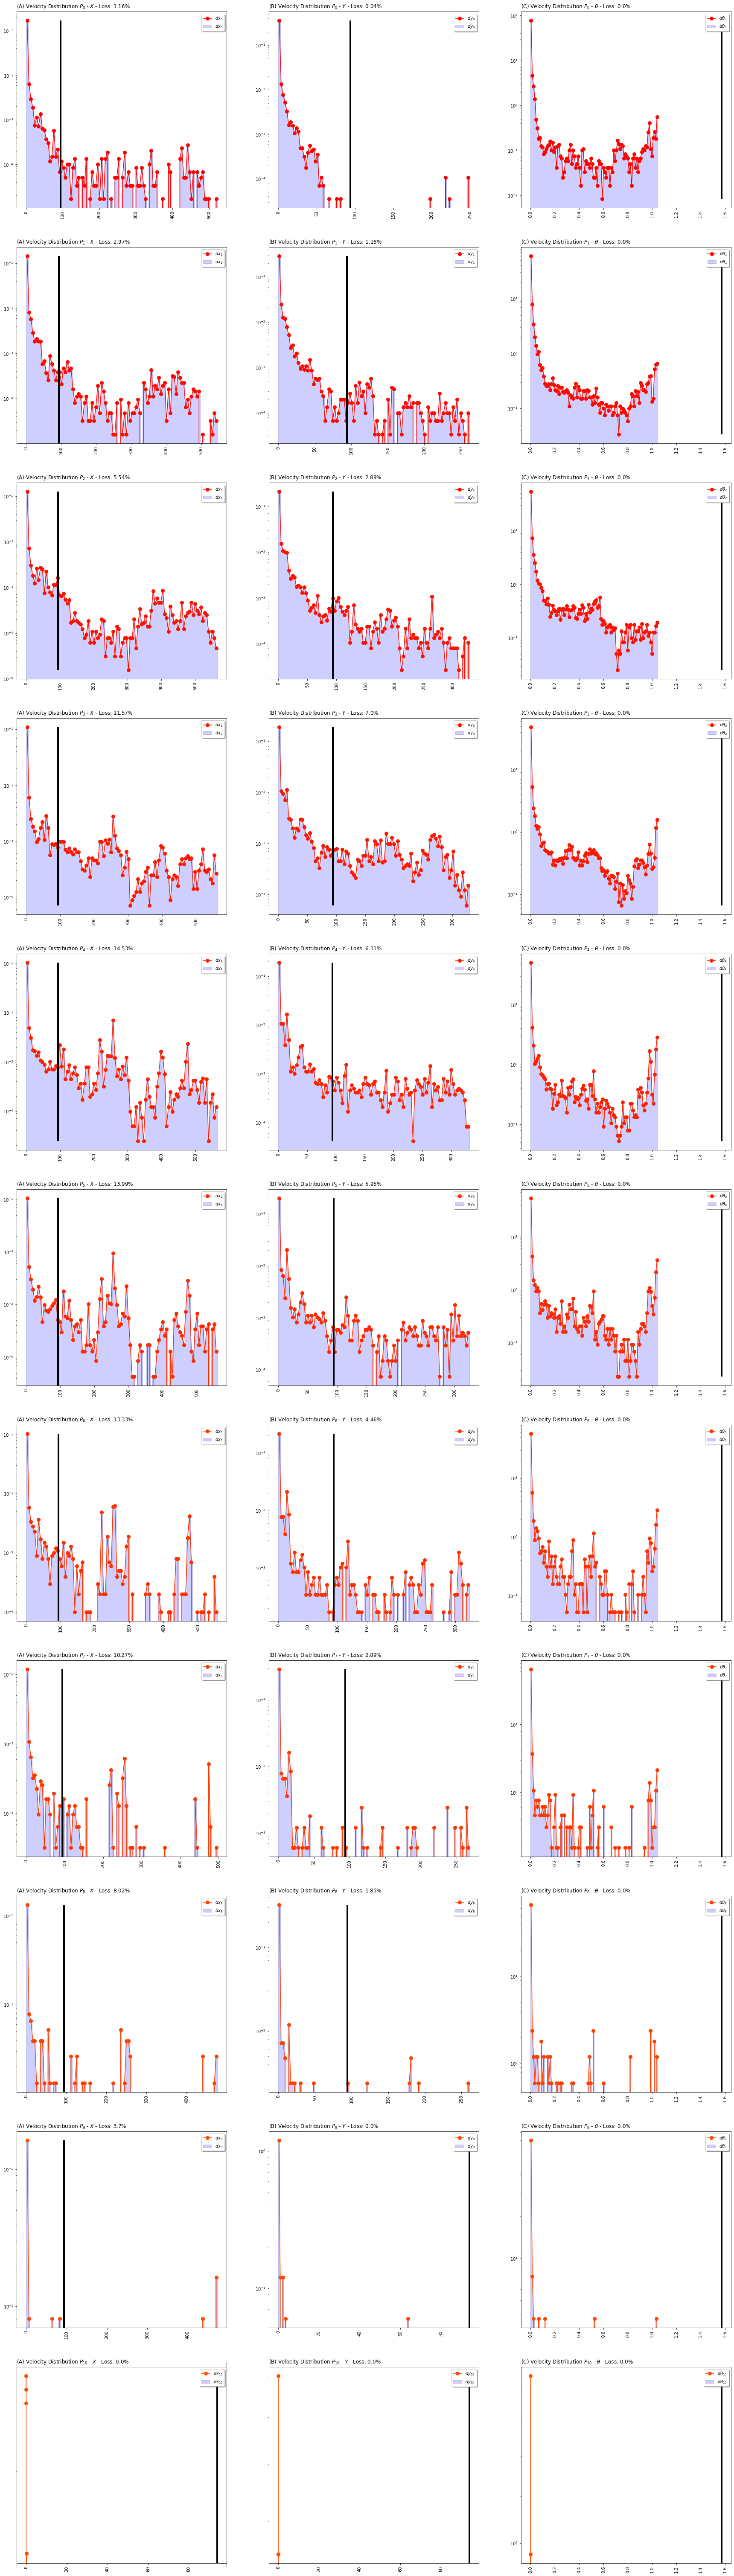

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,4
1,3,3972
2,4,11268
3,5,15373
4,6,14202
5,7,8344
6,8,3688
7,9,1215
8,10,200
9,11,77


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 56.39023265594748 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.005142
1,2,True,False,False,0.001714
2,3,False,False,False,6.499494
3,3,False,True,False,0.183398
4,3,True,False,False,0.089128
5,3,True,True,False,0.035994
6,4,False,False,False,17.775911
7,4,False,True,False,0.627325
8,4,True,False,False,0.654749
9,4,True,True,False,0.255386


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 45.726062341865614 
	- Angle: 56.39023265594748 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.0%
Final loss data X-axis: 0.7397660818713451%
Final loss data Y-axis: 0.4590643274853802%
Final loss data Angle : 0.5409356725146198%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.008772
1,3,False,False,True,0.233918
2,3,False,True,False,0.014620
3,3,False,True,True,0.482456
4,3,True,False,True,0.216374
5,3,True,True,False,0.517544
6,3,True,True,True,98.526316


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 45.726062341865614 
	- Angle: 56.39023265594748 



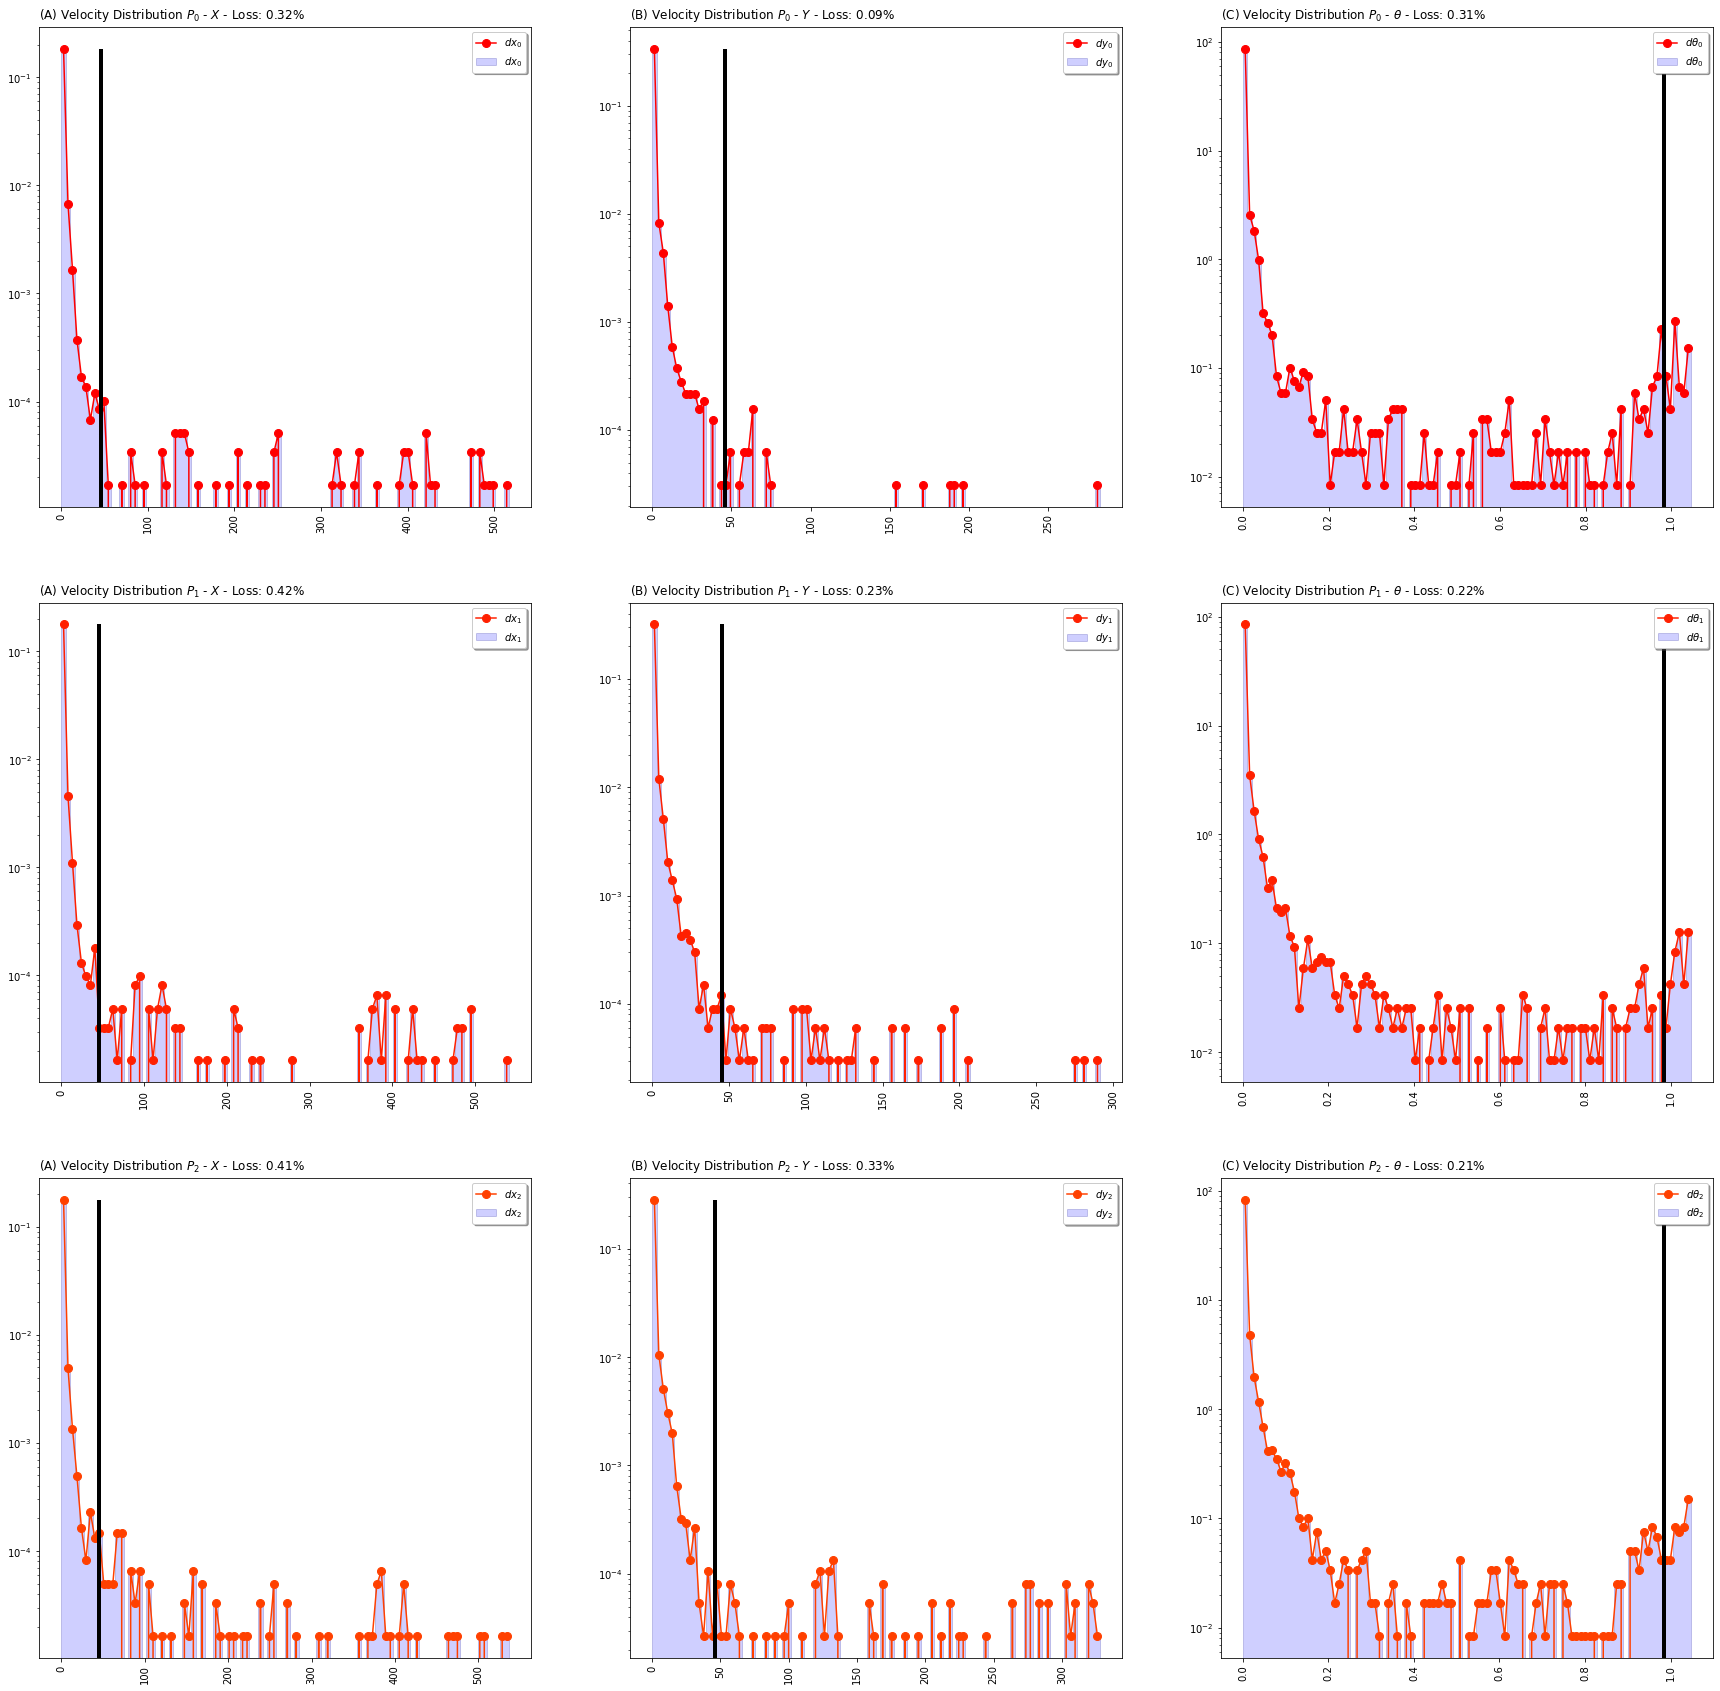

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1565.489817,62.212713,1565.294488,63.157142,NaN,1565.489817,62.212713,NaN,1565.489817,62.212713,-0.909701,4861.0,123.734320,88.244357,0.700985,3,NaN,NaN,NaN,NaN,False,False,False
1325,1,0,1258.034839,161.311574,1257.129357,161.741352,0.0,1180.000000,92.000000,0.603922,1234.000000,109.000000,1.108672,13634.0,310.389452,92.048196,0.955015,3,NaN,NaN,NaN,NaN,False,False,False
2650,2,0,1685.466719,408.644057,1684.806985,411.567807,0.0,1702.000000,324.000000,0.450980,1681.000000,331.000000,-0.070179,6310.0,242.150312,68.500693,0.959154,3,NaN,NaN,NaN,NaN,False,False,False
3975,0,3,1556.509065,67.161713,1556.775389,67.875964,NaN,1556.509065,67.161713,NaN,1556.509065,67.161713,-0.909701,4861.0,123.734320,88.244357,0.700985,3,3.0,-2.993584,1.649667,0.000000,False,False,False
3976,1,3,1258.034839,161.311574,1257.129357,161.741352,0.0,1180.000000,92.000000,0.603922,1234.000000,109.000000,1.108672,13634.0,310.389452,92.048196,0.955015,3,3.0,0.000000,0.000000,0.000000,False,False,False
3977,2,3,1683.637791,412.425943,1682.983554,415.477410,0.0,1690.000000,328.000000,0.450980,1685.500000,421.000000,-0.070179,6310.0,242.150312,68.500693,0.959154,3,3.0,-0.609643,1.260629,0.000000,False,False,False
3979,0,6,1546.901903,74.404456,1546.460805,74.873979,NaN,1546.901903,74.404456,NaN,1546.901903,74.404456,-1.255602,6463.0,191.095350,82.584105,0.901796,3,3.0,-3.202387,2.414248,-0.115301,False,False,False
3978,1,6,1572.975078,77.507788,1571.982751,80.723661,NaN,1572.975078,77.507788,NaN,1572.975078,77.507788,-0.864033,321.0,196.378464,114.708185,0.811669,3,3.0,104.980080,-27.934595,-0.657568,True,False,False
3980,2,6,1671.955709,423.245997,1671.491918,424.704087,0.0,1665.000000,341.000000,0.431373,1709.000000,391.000000,0.053158,6683.0,244.285346,69.763647,0.958354,3,3.0,-3.894028,3.606685,0.041112,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.14it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_1m_2f_240215_1_c.zip'